# EE359-Coursework 4  Streaming Algorithm
Existing codes in this file are just hints. You can modify these codes as you want

## **Task1：DGIM**

DGIM is an efficient algorithm in processing large streams. When it's infeasible to store the flowing binary stream, DGIM can estimate the number of 1-bits in the window. In this coding, you're given the stream_data_dgim.txt (binary stream), and you need to implement the DGIM algorithm to count the number of 1-bits. Write code below.

### 1. Set the window size to 1000, and count the number of 1-bits in the current window.

In [9]:
from collections import defaultdict
# imply DGIM
class DGIM:
    def __init__(self, filepath, windowsize, maxtime = None):
        self.fileHandler = open(filepath, 'r')
        self.windowSize = windowsize
        self.buckets = defaultdict(list)
        self.timeMod = maxtime if maxtime else windowsize << 2
        self.timestamp = 0
    
    def update(self):
        key_list = sorted(self.buckets.keys())
        # remove buckets that are out of window
        max_key = max(key_list)
        # check if the latest bucket is out of window
        if self.timestamp - self.buckets[max_key][0] >= self.windowSize:
                # if so, remove the latest bucket
                self.buckets[max_key].pop(0)
                if len(self.buckets[max_key]) == 0:
                    self.buckets.pop(max_key)
        # merge buckets
        key_list = sorted(self.buckets.keys())
        for key in key_list:
            # check if there is more than 2 buckets
            if len(self.buckets[key]) == 3:
                time_stamp_left = self.buckets[key].pop(0)
                time_stamp_right = self.buckets[key].pop(0)
                self.buckets[key * 2].append(time_stamp_right)

       

    
    def run(self):
        f = self.fileHandler
        x = f.read(2).strip()
        while x:
            if x == '1':
                self.buckets[1].append(self.timestamp)
                self.update()
            self.timestamp = (self.timestamp + 1) % self.timeMod
            x = f.read(2).strip()
    
    def count(self, start):
        count_right = self.timestamp
        count_left = (count_right - start) % self.timeMod
        if count_left > count_right:
            count_right += self.timeMod
        cnt = 0
        # sort keys to save time
        sizes = sorted(self.buckets.keys(), reverse = True)
        for size in sizes:
            for time_stamp in self.buckets[size]:
                if time_stamp >= count_left and time_stamp < count_right:
                    if cnt == 0:
                        cnt += 0.5 * size
                    else:
                        cnt += size
        cnt = int(cnt)
        return cnt

### 2. With the window size 1000, count the number of 1-bits in the last 500 and 200 bits of the bitstream.

In [10]:
import time
start_time = time.time()
# 500 bits
dgim = DGIM('stream_data_dgim.txt', 1000)
dgim.run()
predict_500 = dgim.count(500)
predict_200 = dgim.count(200)
time1 = time.time() - start_time
print("500 bits: ", predict_500)
print("200 bits: ", predict_200)
print("time cost: %s seconds" % (time1))

500 bits:  220
200 bits:  76
time cost: 0.05500626564025879 seconds


### 3. Write a function that accurately counts the number of 1-bits in the current window. Caculate the accuracy of your own DGIM algorithm and compare the running time difference.

In [11]:
# Your code here, you can add cells if necessary
import numpy as np
# import time
def accurateCountTask1():
    start_time = time.time()
    # read file
    f = open('stream_data_dgim.txt', 'r')
    # count the number of 1-bits in the last 500 and 200 bits
    count500 = 0
    count200 = 0
    tool = []
    x = f.read(2).strip()
    while x:
        tool.append(x)
        x = f.read(2).strip()
    count500 = tool[-500:].count('1')
    count200 = tool[-200:].count('1')
    time2 = time.time() - start_time
    eps = 1e-10
    # calculate mean error rate
    mer_500 = abs((predict_500 - count500)/(count500 + eps))
    mer_200 = abs((predict_200 - count200)/(count200 + eps))
    print('The actual number of 1-bits in the last 500 bits is: ', count500)
    print('The actual number of 1-bits in the last 200 bits is: ', count200)
    # print('The accuracy of the accurate count is: ', predict_500 / count500)
    # print('The accuracy of the accurate count is: ', predict_200 / count200)
    print('The mean error rate of the accurate count 500 is: ', mer_500)
    print('The mean error rate of the accurate count 200 is: ', mer_200)
    print('The running time of the accurate count is: ', time2)
    print('time difference: ', time2 - time1)
accurateCountTask1()

The actual number of 1-bits in the last 500 bits is:  190
The actual number of 1-bits in the last 200 bits is:  77
The mean error rate of the accurate count 500 is:  0.15789473684202218
The mean error rate of the accurate count 200 is:  0.012987012986996121
The running time of the accurate count is:  0.009002208709716797
time difference:  -0.04600405693054199


## **Task2: Bloom Filter**

A Bloom filter is a space-efficient probabilistic data structure. Here the task is to implement a bloom filter by yourself. 

### Data loading:

From the NLTK (Natural Language ToolKit) library, we import a large list of English dictionary words, commonly used by the very first spell-checking programs in Unix-like operating systems.

In [12]:
import nltk
from nltk.corpus import words
nltk.download('words')
word_list = words.words()

[nltk_data] Downloading package words to
[nltk_data]     C:\Users\28419\AppData\Roaming\nltk_data...
[nltk_data]   Package words is already up-to-date!


Then we load another dataset from the NLTK Corpora collection: movie_reviews.

The movie reviews are categorized between positive and negative, so we construct a list of words (usually called bag of words) for each category.

In [95]:
from nltk.corpus import movie_reviews
nltk.download('movie_reviews')
neg_reviews = []
pos_reviews = []

for fileid in movie_reviews.fileids('neg'):
  neg_reviews.extend(movie_reviews.words(fileid))
for fileid in movie_reviews.fileids('pos'):
  pos_reviews.extend(movie_reviews.words(fileid))

[nltk_data] Downloading package movie_reviews to
[nltk_data]     C:\Users\28419\AppData\Roaming\nltk_data...
[nltk_data]   Unzipping corpora\movie_reviews.zip.


Here we get a data stream (word_list) and 2 query lists (neg_reviews and pos_reviews).

### 1. Write a function that accurately determines whether each word in neg_reviews and pos_reviews belongs to word_list.

In [98]:
import numpy as np
import time

def linear_search(word_list, target_word):
    return target_word in word_list

In [99]:
# Binary search
neg_flag_b = np.zeros(len(neg_reviews), dtype=bool)
pos_flag_b = np.zeros(len(pos_reviews), dtype=bool)
# to store the accurate result

t = time.time()
sorted_word_list = sorted(word_list)
for i, neg_word in enumerate(neg_reviews):
    neg_flag_b[i] = linear_search(sorted_word_list, neg_word)
for i, pos_word in enumerate(pos_reviews):
    pos_flag_b[i] = linear_search(sorted_word_list, pos_word)
print("Search Time:", time.time() - t)

Search Time: 5290.055406808853


 ### 2. Implement the bloom filter by yourself and add all words in word_list in your bloom filter. Compare the running time difference between exact search (Task2 Question1) and multiple hash computations in a Bloom filter.

In [100]:
# Your code here, you can add cells if necessary
import hashlib

class BloomFilter:
    def __init__(self, m, k):
        self.m = int(m)
        self.k = int(k)
        self.table = np.zeros((self.m), dtype = bool)
    def add(self, item):
        hash1 = hashlib.sha256()
        hash1.update(item.encode())
        hash1 = int(hash1.hexdigest(), 16) % self.m
        hash2 = hashlib.md5()
        hash2.update(item.encode())
        hash2 = int(hash2.hexdigest(), 16) % self.m
        h = hash1
        for i in range(self.k):
            self.table[h] = True
            # h = (h + hash2) % self.m
            h = hash2
    def check(self, item):
        hash1 = hashlib.sha256()
        hash1.update(item.encode())
        hash1 = int(hash1.hexdigest(), 16) % self.m
        hash2 = hashlib.md5()
        hash2.update(item.encode())
        hash2 = int(hash2.hexdigest(), 16) % self.m
        h = hash1
        for i in range(self.k):
            if self.table[h] == False:
                return False
            # h = (h + hash2) % self.m
            h = hash2
        return True

In [101]:
bf = BloomFilter(1e7, 4)
neg_bf = np.zeros(len(neg_reviews), dtype=bool)
pos_bf = np.zeros(len(pos_reviews), dtype=bool)
n = neg_bf.shape[0] + pos_bf.shape[0]
t = time.time()
for word in word_list:
    bf.add(word)
for i, neg_word in enumerate(neg_reviews):
    neg_bf[i] = bf.check(neg_word)
for i, pos_word in enumerate(pos_reviews):
    pos_bf[i] = bf.check(pos_word)
print("Bloom Filter Time:", time.time()-t)
print("Accuracy:")
print(f"neg: {(neg_bf == neg_flag_b).sum()} / {neg_bf.shape[0]}")
print(f"pos: {(pos_bf == pos_flag_b).sum()} / {pos_bf.shape[0]}")

Bloom Filter Time: 11.932997465133667
Accuracy:
neg: 750992 / 751256
pos: 832247 / 832564


由此可见，我们的Bloom Filter在准确率上有所损失，但是在时间上却有了很大的提升。这个时间提升是近百倍的，这是非常可观的。所以，Bloom Filter在一些对准确率要求不高的场景下，是非常有用的。

### 3. Use different bit array length ‘m’ and number of hash functions ‘k’ to implement the bloom filter algorithm. Then compare the impact of different m and k on the false positive rate.

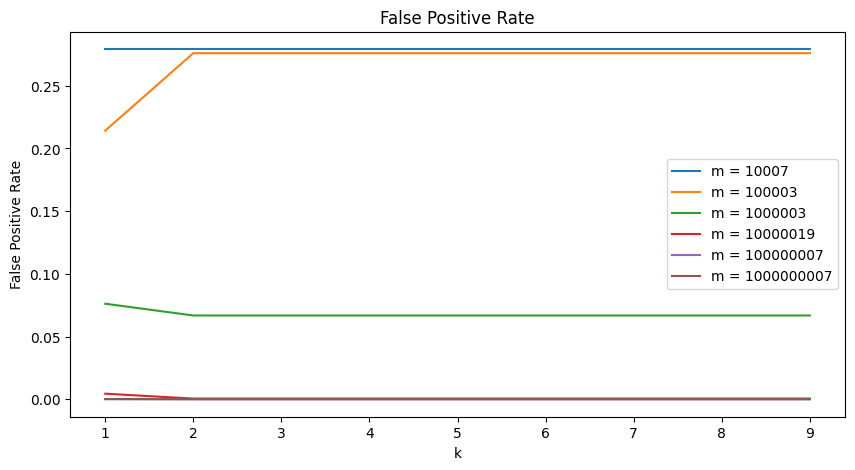

In [104]:
# Your code here, you can add cells if necessary
m_list = [10007, 100003, 1000003, 10000019, 100000007, 1000000007]
k_list = [1, 2, 3, 4, 5, 6, 7, 8, 9]

pos_results = np.zeros((len(m_list), len(k_list)))
neg_results = np.zeros((len(m_list), len(k_list)))

for x, m in enumerate(m_list):
    for j, k in enumerate(k_list):
        bf = BloomFilter(m, k)
        for word in word_list:
            bf.add(word)
        # for i, neg_word in enumerate(neg_reviews):
        #     neg_bf[i] = bf.check(neg_word)
        for i, pos_word in enumerate(pos_reviews):
            pos_bf[i] = bf.check(pos_word)
        # calculate false positive rate
        # for i, neg_word in enumerate(neg_reviews):
        #     if neg_bf[i] == True and neg_flag_b[i] == False:
        #         neg_results[x, j] += 1
        # neg_results[x, j] /= neg_bf.shape[0]
        # calculate false negative rate
        for i, pos_word in enumerate(pos_reviews):
            if pos_bf[i] == True and pos_flag_b[i] == False:
                pos_results[x, j] += 1
        pos_results[x, j] /= pos_bf.shape[0]

import matplotlib.pyplot as plt

ran = range(1, 10)
plt.figure(figsize=(10, 5))
plt.title("False Positive Rate")
plt.xlabel("k")
plt.ylabel("False Positive Rate")
plt.plot(ran, pos_results[0], label="m = 10007")
plt.plot(ran, pos_results[1], label="m = 100003")
plt.plot(ran, pos_results[2], label="m = 1000003")
plt.plot(ran, pos_results[3], label="m = 10000019")
plt.plot(ran, pos_results[4], label="m = 100000007")
plt.plot(ran, pos_results[5], label="m = 1000000007")
plt.legend()
plt.show()



**结论**：当m足够大的时候，FP几乎接近于0了。当m小的时候，k选择1到2比较好。

**m**：m越大，FP越小，但是空间占用、时间占用也越大。

**k**：k越大，时间越多。但是k的大小并不与FP成正比，所以k的选择要根据实际情况来定。

## **Task3: Count-Min sketch**



In computing, the count–min sketch (CM sketch) is a probabilistic data structure that serves as a frequency table of events in a stream of data. 

Here we use the query stream (neg_reviews or pos_reviews) from task 2.

### 1. Write a function that accurately counts the occurrence times of each word in neg_reviews or pos_reviews.

In [117]:
# Your code here, you can add cells if necessary
import tqdm
word_set = set(word_list)
def accCount(words):
    
    acc_dict = {}
    acc_list = []
    for i in tqdm.tqdm(range(len(words))):
        word = words[i]
        if word in acc_dict.keys():
            acc_dict[word] += 1
        else:
            acc_dict[word] = 1
    for word in word_set:
        acc_list.append(acc_dict.get(word, 0))

    return acc_list

neg_accCount = accCount(neg_reviews)

100%|██████████| 751256/751256 [00:00<00:00, 2069580.31it/s]


### 2. Implement the Count-Min sketch by yourself. Set different width w and depth d of the internal data structure of CM-Sketch. Compare the influence of different w and d on the error.

In [113]:
# Your code here, you can add cells if necessary
class CountMin:
    def __init__(self, w, d):
        self.w = int(w)
        self.d = int(d)
        self.table=np.zeros((self.d, self.w), dtype=int)
    def add(self, item):
        for i in range(self.d):
            hash = self.get_hash(item, i)
            self.table[i, hash] += 1

    def get_hash(self, item, d):
        item = str(d) + item + str(d)
        hash = hashlib.md5()
        hash.update(item.encode())
        hash = int(hash.hexdigest(), 16) % self.w
        return hash
    
    def count(self, item):
        min_count = -100
        for d in range(self.d):
            if min_count == -100:
                min_count = self.table[d, self.get_hash(item, d)]
            else:
                min_count = min(min_count, self.get_hash(item, d))

        return min_count

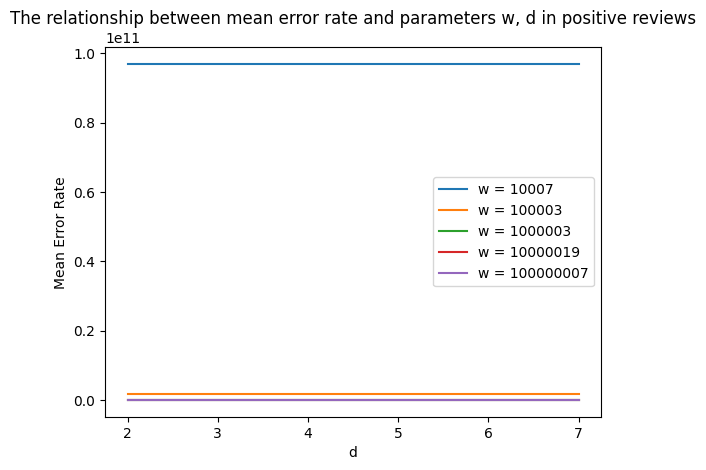

In [118]:
def cm_method(word_list,w,d):
    cm = CountMin(w, d)
    for word in word_list:
        cm.add(word)
    res = []
    for word in word_set:
        res.append(cm.count(word))
    return res
def calc_error_rate(occ_res, occ_gt):
    eps = 1e-10
    err = np.abs((np.array(occ_res) - np.array(occ_gt))) / (np.array(occ_gt) + eps)
    return err.mean(), err.max()

w_list = [10007, 100003, 1000003, 10000019, 100000007]
d_list = [2,3,4,5,6,7]
# pos_occ_results_mean = np.zeros((len(w_list), len(d_list)))
neg_occ_results_mean = np.zeros((len(w_list), len(d_list)))
# pos_occ_results_max = np.zeros((len(w_list), len(d_list)))
neg_occ_results_max = np.zeros((len(w_list), len(d_list)))
for i, w in enumerate(w_list):
    for j, d in enumerate(d_list):
        # pos_occ_res_t = cm_method(pos_reviews, w = w, d = d)
        neg_occ_res_t = cm_method(neg_reviews, w = w, d = d)
        # pos_mean_err_rate, pos_max_err_rate = calc_error_rate(pos_occ_res_t, pos_accCount)
        neg_mean_err_rate, neg_max_err_rate = calc_error_rate(neg_occ_res_t, neg_accCount)
        # pos_occ_results_mean[i, j] = pos_mean_err_rate
        neg_occ_results_mean[i, j] = neg_mean_err_rate
        # pos_occ_results_max[i, j] = pos_max_err_rate
        neg_occ_results_max[i, j] = neg_max_err_rate

x = range(2,8)
plt.plot(x, neg_occ_results_mean[0, :], label = 'w = 10007')
plt.plot(x, neg_occ_results_mean[1, :], label = 'w = 100003')
plt.plot(x, neg_occ_results_mean[2, :], label = 'w = 1000003')
plt.plot(x, neg_occ_results_mean[3, :], label = 'w = 10000019')
plt.plot(x, neg_occ_results_mean[4, :], label = 'w = 100000007')
plt.legend()
plt.xlabel("d")
plt.ylabel("Mean Error Rate") 
plt.title("The relationship between mean error rate and parameters w, d in positive reviews")
plt.show()


**结论**：可以看到，当w小的时候，mer仍然很高；当w大的时候，mer越来越接近于0，并最终收敛到0。

**w**：w越大，mer越低，但是浪费更多空间。

**d**：在这个数据上，d的影响不大。但是维度小的时候，mer变大是必然的，维度越大mer越小，但是浪费时间也越多。